In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# FOR COLAB: Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
from google.colab import drive
from tqdm.notebook import tqdm # Import tqdm for the progress bar

# comment out once data is imported:

# # Define the path to your zip file and the target directory for extraction
# zip_file_path = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/data.zip'
# extract_dir = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/data'


# # Create the target directory if it doesn't exist
# os.makedirs(extract_dir, exist_ok=True)

# # Extract all content from the zip file with a progress bar
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     files_to_extract = zip_ref.infolist() # Get all files to extract

#     for member in tqdm(files_to_extract, desc="Extracting files"):
#         try:
#             zip_ref.extract(member, extract_dir)
#         except Exception as e:
#             print(f"Error extracting {member.filename}: {e}")

# print(f"Extraction complete. Files extracted to: {extract_dir}")

In [ ]:
# FOR COLAB Define the dataset directory
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/data/data'

In [ ]:
# Count number of items per folder
import os

# List all items in the dataset directory
items = os.listdir(dataset_dir)

# Filter for folders
folders = [item for item in items if os.path.isdir(os.path.join(dataset_dir, item))]

# Sort the folders list alphabetically
folders.sort()

# Initialize the counts dictionary
counts = {}

# Count number of files in each folder
files_counts = {}
for folder in folders:
    folder_path = os.path.join(dataset_dir, folder)
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.fasta'))]
    counts[folder] = len(files)

# Print the image counts for each folder
print("Number of files per folder:")
for folder, count in counts.items():
    print(f"{folder}: {count}")

Number of images per folder:
Dengue1: 1899
Dengue2: 1631
Dengue3: 995
Dengue4: 236
Japanese_Encephalitis_Virus: 518
West_Nile_Virus: 2064
Zika: 350


### Data encoding

In [ ]:
# Set Up

# Each nucleotide is represented as a 4-element vector.
# N (any base) or other unexpected characters will be encoded as all zeros.
NUCLEOTIDE_MAP = {
    'A': [1, 0, 0, 0],
    'C': [0, 1, 0, 0],
    'G': [0, 0, 1, 0],
    'T': [0, 0, 0, 1],
    'N': [0, 0, 0, 0] # Represent 'N' as all zeros
}
# Default encoding for any character not in NUCLEOTIDE_MAP (e.g., 'R', 'Y', etc.)
UNKNOWN_NUCLEOTIDE_ENCODING = [0, 0, 0, 0]

In [ ]:
# Encode all data according to the nucleotide map given

import numpy as np
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
from tensorflow.keras.utils import to_categorical # Import to_categorical
import os # Import os
from tqdm.notebook import tqdm # Ensure tqdm is imported here as well for clarity and robustness


# Function to encode a single DNA sequence
def encode_sequence(sequence, nucleotide_map):
    encoded_sequence = []
    for nucleotide in sequence.upper():  # Convert to uppercase for case-insensitivity
        encoded_sequence.append(nucleotide_map.get(nucleotide, UNKNOWN_NUCLEOTIDE_ENCODING))
    return np.array(encoded_sequence)

# Function to load, encode, and label data
def load_and_encode_data(dataset_dir, nucleotide_map):
    all_sequences = []
    all_labels = []
    label_encoder = LabelEncoder()

    # Get the class names from the folder names
    class_names = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
    print(f"Found classes: {class_names}")

    for class_name in tqdm(class_names, desc="Processing classes"):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.lower().endswith(('.fasta')):
                    filepath = os.path.join(class_dir, filename)
                    try:
                        # Assuming each .fasta file contains one sequence
                        with open(filepath, 'r') as f:
                            sequence_lines = []
                            for line in f:
                                if not line.strip().startswith('>'): # Skip header lines
                                    sequence_lines.append(line.strip())
                            sequence = "".join(sequence_lines)

                        if sequence: # Only process non-empty sequences
                            encoded_seq = encode_sequence(sequence, nucleotide_map)
                            all_sequences.append(encoded_seq)
                            all_labels.append(class_name)
                    except Exception as e:
                        print(f"Error processing file {filepath}: {e}")

    # Convert labels to numerical format
    encoded_labels = label_encoder.fit_transform(all_labels)
    # Convert numerical labels to one-hot encoding
    one_hot_labels = to_categorical(encoded_labels, num_classes=len(class_names))

    return all_sequences, one_hot_labels, label_encoder.classes_

# Load and encode the data
# This might take a while depending on the size of your dataset
sequences, labels, class_names = load_and_encode_data(dataset_dir, NUCLEOTIDE_MAP)

print(f"Loaded {len(sequences)} sequences with shape {sequences[0].shape if sequences else 'N/A'}")
print(f"Loaded {len(labels)} labels with shape {labels[0].shape if len(labels) > 0 else 'N/A'}")
print(f"Class names: {class_names}")

# Before padding, find the maximum sequence length
max_sequence_length = max(len(seq) for seq in sequences) if sequences else 0
print(f"Maximum sequence length found: {max_sequence_length}")

print(f"Padding sequences to a maximum length of: {max_sequence_length}")


# padding sequences

# def seq_padding(sequences, max_sequence_length):
#   padded_sequences = np.zeros((len(sequences), max_sequence_length, sequences[0].shape[1]), dtype=np.float32)

#   for i, seq in enumerate(sequences):
#       seq_length = seq.shape[0]
#       padded_sequences[i, :seq_length, :] = seq

# print(f"Shape of padded sequences: {padded_sequences.shape}")


Found classes: ['Dengue1', 'Dengue2', 'Dengue3', 'Dengue4', 'Japanese_Encephalitis_Virus', 'West_Nile_Virus', 'Zika']


Processing classes:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded 7693 sequences with shape (10690, 4)
Loaded 7693 labels with shape (7,)
Class names: ['Dengue1' 'Dengue2' 'Dengue3' 'Dengue4' 'Japanese_Encephalitis_Virus'
 'West_Nile_Virus' 'Zika']
Maximum sequence length found: 11520


In [ ]:
# prompt: perfprm padding and save all encoded data in correct file format.

import numpy as np
# Padding the sequences
# We need to pad the sequences to the maximum length found.
# This ensures all input sequences have the same dimension for the model.

# Determine the maximum sequence length
# (This was done in the previous cell, but repeating for clarity if running this cell independently)
max_sequence_length = max(len(seq) for seq in sequences) if sequences else 0
print(f"Padding sequences to a maximum length of: {max_sequence_length}")

# Pad the sequences using np.pad
# We pad with zeros at the end of each sequence.
# The padding needs to match the shape of the encoded nucleotides [1, 0, 0, 0], so we pad axis 0.
padded_sequences = np.zeros((len(sequences), max_sequence_length, sequences[0].shape[1]), dtype=np.float32)

for i, seq in enumerate(sequences):
    seq_length = seq.shape[0]
    padded_sequences[i, :seq_length, :] = seq

print(f"Shape of padded sequences: {padded_sequences.shape}")

# Define the path to save the processed data
save_path = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/processed_data'
os.makedirs(save_path, exist_ok=True)

# Save the padded sequences and labels using numpy's save function
# This saves them in a binary .npy format, which is efficient for numpy arrays.
np.save(os.path.join(save_path, 'padded_sequences.npy'), padded_sequences)
np.save(os.path.join(save_path, 'labels.npy'), labels)
np.save(os.path.join(save_path, 'class_names.npy'), class_names) # Also save class names

print(f"Padded sequences saved to: {os.path.join(save_path, 'padded_sequences.npy')}")
print(f"Labels saved to: {os.path.join(save_path, 'labels.npy')}")
print(f"Class names saved to: {os.path.join(save_path, 'class_names.npy')}")

Padding sequences to a maximum length of: 11520
Shape of padded sequences: (7693, 11520, 4)
Padded sequences saved to: /content/drive/MyDrive/Colab Notebooks/VectorizeDNA/processed_data/padded_sequences.npy
Labels saved to: /content/drive/MyDrive/Colab Notebooks/VectorizeDNA/processed_data/labels.npy
Class names saved to: /content/drive/MyDrive/Colab Notebooks/VectorizeDNA/processed_data/class_names.npy


In [ ]:
# prompt: split data to training, validation and testing data sets
# use only a maximum of 500 samples for training for all classes.

import numpy as np
# Load the saved data
load_path = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/processed_data'
padded_sequences = np.load(os.path.join(load_path, 'padded_sequences.npy'))
labels = np.load(os.path.join(load_path, 'labels.npy'))
class_names = np.load(os.path.join(load_path, 'class_names.npy'))

print(f"Loaded padded sequences shape: {padded_sequences.shape}")
print(f"Loaded labels shape: {labels.shape}")
print(f"Loaded class names: {class_names}")

# Stratified splitting to maintain class distribution
# Split data into training+validation and test sets (e.g., 80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    padded_sequences,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels # Use original labels for stratification
)

# Split the training+validation set into training and validation sets (e.g., 70% train, 30% val of the train+val set)
# This results in approximately 56% train, 24% val, 20% test of the original data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.3, # 0.3 of 0.8 is 0.24
    random_state=42,
    stratify=y_train_val # Use combined train+val labels for stratification
)

print(f"Shape of training set: {X_train.shape}")
print(f"Shape of validation set: {X_val.shape}")
print(f"Shape of test set: {X_test.shape}")

# Limit the training data size to a maximum of 500 samples per class
max_samples_per_class = 500
train_indices_to_keep = []
train_labels_numerical = np.argmax(y_train, axis=1) # Convert one-hot back to numerical for counting

for class_idx in range(y_train.shape[1]):
    # Find indices for the current class in the training set
    class_indices = np.where(train_labels_numerical == class_idx)[0]

    # Randomly sample up to max_samples_per_class from these indices
    if len(class_indices) > max_samples_per_class:
        sampled_indices = np.random.choice(class_indices, max_samples_per_class, replace=False)
        train_indices_to_keep.extend(sampled_indices)
    else:
        # Keep all samples if less than max_samples_per_class
        train_indices_to_keep.extend(class_indices)

# Shuffle the indices to avoid any class order bias
np.random.shuffle(train_indices_to_keep)

# Filter the training data using the selected indices
X_train_limited = X_train[train_indices_to_keep]
y_train_limited = y_train[train_indices_to_keep]

print(f"Shape of limited training set (max {max_samples_per_class} per class): {X_train_limited.shape}")
print(f"Shape of validation set (after splitting): {X_val.shape}")
print(f"Shape of test set (after splitting): {X_test.shape}")

# Verify the number of samples per class in the limited training set
limited_train_labels_numerical = np.argmax(y_train_limited, axis=1)
unique_classes, counts = np.unique(limited_train_labels_numerical, return_counts=True)
print("\nNumber of samples per class in the limited training set:")
for class_idx, count in zip(unique_classes, counts):
    print(f"Class {class_names[class_idx]}: {count} samples")


Loaded padded sequences shape: (7693, 11520, 4)
Loaded labels shape: (7693, 7)
Loaded class names: ['Dengue1' 'Dengue2' 'Dengue3' 'Dengue4' 'Japanese_Encephalitis_Virus'
 'West_Nile_Virus' 'Zika']
Shape of training set: (4307, 11520, 4)
Shape of validation set: (1847, 11520, 4)
Shape of test set: (1539, 11520, 4)
Shape of limited training set (max 500 per class): (2618, 11520, 4)
Shape of validation set (after splitting): (1847, 11520, 4)
Shape of test set (after splitting): (1539, 11520, 4)

Number of samples per class in the limited training set:
Class Dengue1: 500 samples
Class Dengue2: 500 samples
Class Dengue3: 500 samples
Class Dengue4: 132 samples
Class Japanese_Encephalitis_Virus: 290 samples
Class West_Nile_Virus: 500 samples
Class Zika: 196 samples


### model structure

In [ ]:
# --- 3. Define the CNN Model Structure ---

# Input shape for Conv2D should be (height, width, channels)
# Here, 'height' is your sequence length, 'width' is 1 (the dummy dimension we added),
# and 'channels' is 4 (for A, C, G, T).
input_shape_for_conv2d = (X_train.shape[1], 1, X_train.shape[2])

model = models.Sequential()

# Input Layer: Specifies the expected shape of individual samples (excluding batch size)
# The Conv2D layer expects a 4D input (batch_size, height, width, channels).
# We are defining the shape for a single sample (height, width, channels).
model.add(layers.Input(shape=input_shape_for_conv2d))

# Convolutional Layers
# Kernel size should be appropriate for the input shape (height, width)
# Since width is 1, the kernel width should also be 1.
model.add(layers.Conv2D(16, kernel_size=(21, 1), strides=(10, 1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 1)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
# Make sure 'num_classes' is defined. It should be the number of unique classes in your dataset.
# Based on the output of cell 'kV00Fernlt_l', this is 7.
num_classes = len(class_names)
model.add(layers.Dense(num_classes, activation='softmax'))

# Print a summary of the model to see the layer outputs and parameter counts
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1152, 1, 16)    │         1,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 576, 1, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        64,519 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,879 (257.34 KB)

 Trainable params: 65,879 (257.34 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# prompt: fit and train the model with the sampled training and validation data

# Train the model with the sampled training and validation data
epochs = 10 # Define the number of training epochs
batch_size = 32 # Define the batch size

# Reshape the input data to match the model's expected input shape (batch_size, height, width, channels)
# The model expects (None, 11520, 1, 4), and our data is (num_samples, 11520, 4)
# We need to add a dimension of size 1 at axis 2 (the 'width' dimension).
X_train_limited_reshaped = np.expand_dims(X_train_limited, axis=2)
X_val_reshaped = np.expand_dims(X_val, axis=2)

print(f"Shape of reshaped training data: {X_train_limited_reshaped.shape}")
print(f"Shape of reshaped validation data: {X_val_reshaped.shape}")

# Clear the Keras session to reset the model state
tf.keras.backend.clear_session()

# Re-define and re-compile the model (assuming the model definition is in a previous cell)
# You would typically redefine your model here if the definition wasn't in a separate cell.
# Since the model is defined in cell 'JjNBRMRkoKfP' and compiled in cell 'gpdaHXzborcs',
# we need to re-execute those cells or include the model definition and compilation here.
# For simplicity and to keep the notebook structure, I'll assume you will re-run the
# model definition and compilation cells before running this one.

# However, to make this cell runnable independently after an error,
# I will include a minimal re-compilation step.
# If you significantly change the model structure, you should re-run the definition cell too.

# Re-compile the model with the same optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # Re-define optimizer
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(
    X_train_limited_reshaped, # Use the reshaped training data
    y_train_limited, # Use the labels for the limited training data (NumPy array)
    epochs=epochs,
    batch_size=batch_size, # Specify the batch size here
    validation_data=(X_val_reshaped, y_val) # Use the reshaped validation data and labels (NumPy arrays)
)

print("\nModel training complete.")

# You can access training history like this:
# history.history['loss']
# history.history['accuracy']
# history.history['val_loss']
# history.history['val_accuracy']

Shape of reshaped training data: (2618, 11520, 1, 4)
Shape of reshaped validation data: (1847, 11520, 1, 4)
Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.4880 - loss: 1.5409 - val_accuracy: 0.8165 - val_loss: 0.6892
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.8204 - loss: 0.6822 - val_accuracy: 0.9096 - val_loss: 0.4561
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.8897 - loss: 0.4598 - val_accuracy: 0.9285 - val_loss: 0.3332
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9282 - loss: 0.3268 - val_accuracy: 0.9329 - val_loss: 0.2715
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9497 - loss: 0.2458 - val_accuracy: 0.9459 - val_loss: 0.2375
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9536 - loss: 0.2059 - val_accuracy: 0.9589 - val_loss: 0.1790
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9771 - loss: 0.1441 - val_accuracy: 0.9637 - val_loss: 0.1500


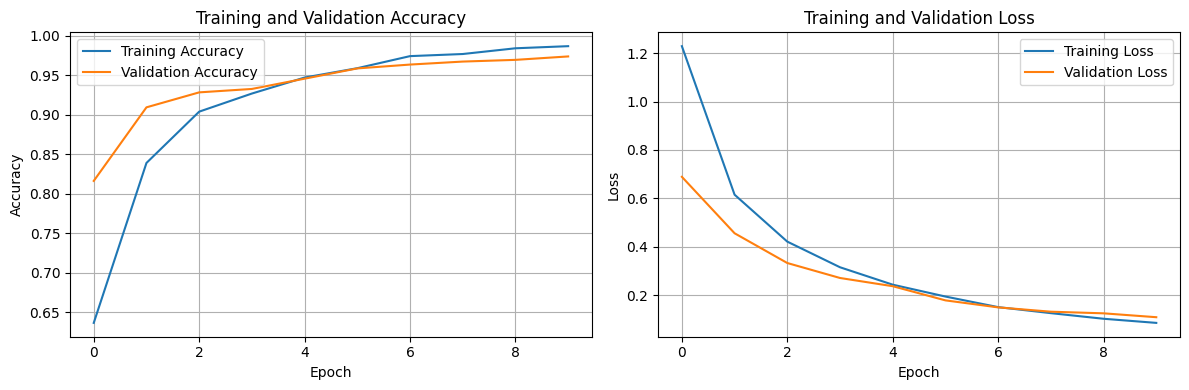

In [ ]:
# prompt: plot training and validation loss and accuracy graphs

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#save the model

model.save('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/models/model5a_flavi.keras')

In [ ]:
# Load the model
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/models/model5a_flavi.keras')

In [ ]:
# 1. Get predictions from the model
# model.predict returns probabilities for each class

# Reshape X_test to match the model's expected input shape (batch_size, height, width, channels)
# The model expects (None, 11520, 1, 4), and X_test is (num_samples, 11520, 4)
# We need to add a dimension of size 1 at axis 2 (the 'width' dimension).
X_test_reshaped = np.expand_dims(X_test, axis=2)

y_pred_probabilities = model.predict(X_test_reshaped)

# 2. Convert probabilities to predicted class labels
# np.argmax will give you the index of the highest probability
predicted_integer_labels = np.argmax(y_pred_probabilities, axis=1)

# Re-initialize LabelEncoder and fit with loaded class_names
# This is needed because label_encoder might not be in the current scope if the kernel was reset
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(class_names)


# 3. If you want to see the human-readable HA types,
# use the label_encoder to inverse transform the integer labels
predicted_virus_types = label_encoder.inverse_transform(predicted_integer_labels)

# 4. Get the true labels in human-readable format for comparison
true_integer_labels = np.argmax(y_test, axis=1) # Convert y_test back from one-hot to integer
true_virus_types = label_encoder.inverse_transform(true_integer_labels)


# Overall model performance
# Evaluate the model on the reshaped test data
loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Test Loss: 0.0995
Test Accuracy: 0.9779


<Figure size 1000x800 with 0 Axes>

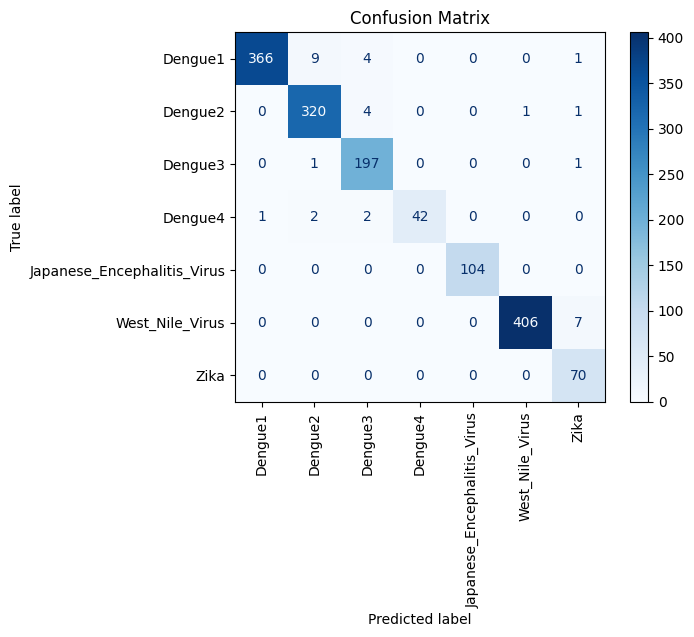


Confusion matrix generated.
[[366   9   4   0   0   0   1]
 [  0 320   4   0   0   1   1]
 [  0   1 197   0   0   0   1]
 [  1   2   2  42   0   0   0]
 [  0   0   0   0 104   0   0]
 [  0   0   0   0   0 406   7]
 [  0   0   0   0   0   0  70]]


In [ ]:
# prompt: can you generate a confusion matrix for the test data

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(true_integer_labels, predicted_integer_labels)

# Get the class names
class_names = label_encoder.classes_

# Display the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

print("\nConfusion matrix generated.")
print(cm)

### test dataset

In [ ]:
import os
import zipfile
from google.colab import drive
from tqdm.notebook import tqdm # Import tqdm for the progress bar

# comment out once data is imported:

# # Define the path to your zip file and the target directory for extraction
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/testdata.zip'
extract_dir = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/testdata'


# # Create the target directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract all content from the zip file with a progress bar
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    files_to_extract = zip_ref.infolist() # Get all files to extract

    for member in tqdm(files_to_extract, desc="Extracting files"):
        try:
            zip_ref.extract(member, extract_dir)
        except Exception as e:
            print(f"Error extracting {member.filename}: {e}")

print(f"Extraction complete. Files extracted to: {extract_dir}")

Extracting files:   0%|          | 0/167 [00:00<?, ?it/s]

Extraction complete. Files extracted to: /content/drive/MyDrive/Colab Notebooks/VectorizeDNA/testdata


In [ ]:
testdata = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/testdata'

In [ ]:
# Count number of items per folder
import os

# List all items in the dataset directory
items = os.listdir(testdata)

# Filter for folders
folders = [item for item in items if os.path.isdir(os.path.join(testdata, item))]

# Sort the folders list alphabetically
folders.sort()

# Initialize the counts dictionary
counts = {}

# Count number of files in each folder
files_counts = {}
for folder in folders:
    folder_path = os.path.join(testdata, folder)
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.fasta'))]
    counts[folder] = len(files)

# Print the image counts for each folder
print("Number of files per folder:")
for folder, count in counts.items():
    print(f"{folder}: {count}")

Number of files per folder:
Dengue1: 25
Dengue2: 25
Dengue3: 25
Dengue4: 20
JEV: 20
WNV: 25
Zika: 20


In [ ]:
# Set Up

# Each nucleotide is represented as a 4-element vector.
# N (any base) or other unexpected characters will be encoded as all zeros.
NUCLEOTIDE_MAP = {
    'A': [1, 0, 0, 0],
    'C': [0, 1, 0, 0],
    'G': [0, 0, 1, 0],
    'T': [0, 0, 0, 1],
    'N': [0, 0, 0, 0] # Represent 'N' as all zeros
}
# Default encoding for any character not in NUCLEOTIDE_MAP (e.g., 'R', 'Y', etc.)
UNKNOWN_NUCLEOTIDE_ENCODING = [0, 0, 0, 0]

In [ ]:
# prompt: encode the sequences in the testdata directory as before. This dataset is for evaluating the model only and not for training.

import numpy as np
# Function to load, encode, and label test data
def load_and_encode_test_data(dataset_dir, nucleotide_map, class_names):
    all_sequences = []
    all_labels = []
    label_encoder = LabelEncoder()
    label_encoder.fit(class_names) # Fit the encoder with the class names used during training

    print(f"Using classes for encoding test data: {class_names}")

    # Iterate through the classes present in the training data's class_names
    for class_name in tqdm(class_names, desc="Processing test classes"):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir): # Check if this class directory exists in the test set
            for filename in os.listdir(class_dir):
                if filename.lower().endswith(('.fasta')):
                    filepath = os.path.join(class_dir, filename)
                    try:
                        # Assuming each .fasta file contains one sequence
                        with open(filepath, 'r') as f:
                            sequence_lines = []
                            for line in f:
                                if not line.strip().startswith('>'): # Skip header lines
                                    sequence_lines.append(line.strip())
                            sequence = "".join(sequence_lines)

                        if sequence: # Only process non-empty sequences
                            encoded_seq = encode_sequence(sequence, nucleotide_map)
                            all_sequences.append(encoded_seq)
                            all_labels.append(class_name)
                    except Exception as e:
                        print(f"Error processing file {filepath}: {e}")

    # Convert labels to numerical format using the fitted encoder
    encoded_labels = label_encoder.transform(all_labels)
    # Convert numerical labels to one-hot encoding
    one_hot_labels = to_categorical(encoded_labels, num_classes=len(class_names))

    return all_sequences, one_hot_labels

# Load and encode the test data using the defined testdata directory
# Use the class_names that were loaded/saved from the training data processing
test_sequences, test_labels = load_and_encode_test_data(testdata, NUCLEOTIDE_MAP, class_names)

print(f"Loaded {len(test_sequences)} test sequences with shape {test_sequences[0].shape if test_sequences else 'N/A'}")
print(f"Loaded {len(test_labels)} test labels with shape {test_labels[0].shape if len(test_labels) > 0 else 'N/A'}")

# Pad the test sequences to the same maximum length used for training
# We need the max_sequence_length from the training data processing
# If the variable max_sequence_length is not in the current scope,
# load it or determine it again from the padded_sequences used for training.
# Assuming max_sequence_length is available from the previous cells.

print(f"Padding test sequences to the training max length of: {max_sequence_length}")

padded_test_sequences = np.zeros((len(test_sequences), max_sequence_length, test_sequences[0].shape[1]), dtype=np.float32)

for i, seq in enumerate(test_sequences):
    seq_length = seq.shape[0]
    if seq_length > max_sequence_length:
        # Optionally trim sequences that are longer than the max training length
        # Or pad to the test set's max length if it's larger (which would require model changes)
        # For now, assuming test sequences should not exceed training max length or are trimmed.
        print(f"Warning: Test sequence {i} is longer than max training length. Trimming.")
        padded_test_sequences[i, :max_sequence_length, :] = seq[:max_sequence_length, :]
    else:
        padded_test_sequences[i, :seq_length, :] = seq

print(f"Shape of padded test sequences: {padded_test_sequences.shape}")

# Save the processed test data
save_path = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/processed_data' # Save in the same directory
os.makedirs(save_path, exist_ok=True)

np.save(os.path.join(save_path, 'padded_test_sequences.npy'), padded_test_sequences)
np.save(os.path.join(save_path, 'test_labels.npy'), test_labels)

print(f"Padded test sequences saved to: {os.path.join(save_path, 'padded_test_sequences.npy')}")
print(f"Test labels saved to: {os.path.join(save_path, 'test_labels.npy')}")

# Load the saved test data (optional, for verification or later use)
loaded_test_sequences = np.load(os.path.join(save_path, 'padded_test_sequences.npy'))
loaded_test_labels = np.load(os.path.join(save_path, 'test_labels.npy'))

print(f"Loaded padded test sequences shape: {loaded_test_sequences.shape}")
print(f"Loaded test labels shape: {loaded_test_labels.shape}")

Using classes for encoding test data: ['Dengue1' 'Dengue2' 'Dengue3' 'Dengue4' 'Japanese_Encephalitis_Virus'
 'West_Nile_Virus' 'Zika']


Processing test classes:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded 115 test sequences with shape (10735, 4)
Loaded 115 test labels with shape (7,)
Padding test sequences to the training max length of: 11520
Shape of padded test sequences: (115, 11520, 4)
Padded test sequences saved to: /content/drive/MyDrive/Colab Notebooks/VectorizeDNA/processed_data/padded_test_sequences.npy
Test labels saved to: /content/drive/MyDrive/Colab Notebooks/VectorizeDNA/processed_data/test_labels.npy
Loaded padded test sequences shape: (115, 11520, 4)
Loaded test labels shape: (115, 7)


Found test folders: ['Dengue1', 'Dengue2', 'Dengue3', 'Dengue4', 'JEV', 'WNV', 'Zika']


Processing test folders:   0%|          | 0/7 [00:00<?, ?it/s]

Padding test sequences to the training max length of: 11520
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Test Results DataFrame:
          File Name True Label Predicted Label  Probability_Dengue1  \
0  AB178040.1.fasta    Dengue1         Dengue1             0.995239   
1  AY732481.1.fasta    Dengue1         Dengue1             0.993849   
2  EU081226.1.fasta    Dengue1         Dengue1             0.995383   
3  EU081263.1.fasta    Dengue1         Dengue1             0.995366   
4  FJ024464.1.fasta    Dengue1         Dengue1             0.997007   

   Probability_Dengue2  Probability_Dengue3  Probability_Dengue4  \
0             0.002074             0.001028             0.000533   
1             0.002328             0.001335             0.000623   
2             0.001960             0.001082             0.000493   
3             0.001932             0.001115             0.000503   
4             0.001118             0.001090             0.000335   

   Probability_Japanese_Encephalitis_Viru

<Figure size 1000x800 with 0 Axes>

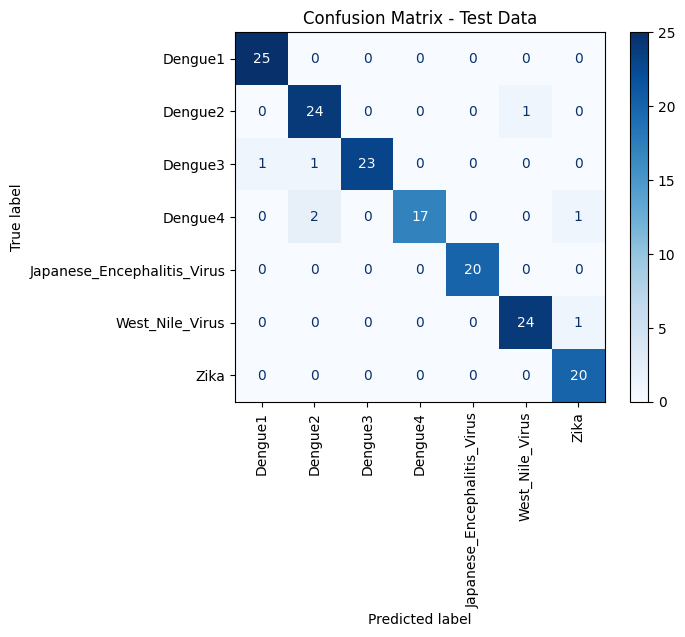


Confusion Matrix:
[[25  0  0  0  0  0  0]
 [ 0 24  0  0  0  1  0]
 [ 1  1 23  0  0  0  0]
 [ 0  2  0 17  0  0  1]
 [ 0  0  0  0 20  0  0]
 [ 0  0  0  0  0 24  1]
 [ 0  0  0  0  0  0 20]]


In [ ]:
# prompt: use the model on the test data. generate predictions. compile results in a dataframe with file name, true label and predicted label, and save it as a csv.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder # Ensure LabelEncoder is imported

# Ensure label_encoder and class_names are available
# We will re-initialize label_encoder and fit it with the class_names loaded previously
# Assuming class_names was loaded in cell 'kV00Fernlt_l' or '790b3uPNwMGB'
try:
    # Attempt to use the existing label_encoder if it's in scope and fitted
    label_encoder.classes_
except NameError:
    # If label_encoder is not defined, re-initialize and fit it
    label_encoder = LabelEncoder()
    # Assuming class_names is available from a previous cell
    label_encoder.fit(class_names)
except AttributeError:
    # If label_encoder is defined but not fitted, fit it
     label_encoder.fit(class_names)


# Redefine the function to load, encode test data and capture filenames
# This function will now also explicitly handle the mapping of test folder names
# to training class names if they differ.
def load_and_encode_test_data_with_filenames(dataset_dir, nucleotide_map, label_encoder, class_names):
    all_sequences = []
    all_labels_text = [] # Store original text labels from filenames
    all_filenames = []

    # Create a mapping from test folder names to training class names
    # This assumes you know the mapping, e.g., 'JEV' in test maps to 'Japanese_Encephalitis_Virus' in training
    # And 'WNV' in test maps to 'West_Nile_Virus' in training.
    test_folder_to_train_class_map = {
        'Dengue1': 'Dengue1',
        'Dengue2': 'Dengue2',
        'Dengue3': 'Dengue3',
        'Dengue4': 'Dengue4',
        'JEV': 'Japanese_Encephalitis_Virus',
        'WNV': 'West_Nile_Virus',
        'Zika': 'Zika'
    }

    # Get the list of folders in the test data directory
    test_folders = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
    print(f"Found test folders: {test_folders}")


    for folder_name in tqdm(test_folders, desc="Processing test folders"):
        # Get the corresponding training class name using the mapping
        # If a test folder doesn't have a mapping, it will be skipped
        if folder_name in test_folder_to_train_class_map:
             train_class_name = test_folder_to_train_class_map[folder_name]
             # Check if this mapped training class name is in the class_names used for training
             if train_class_name in label_encoder.classes_:
                class_dir = os.path.join(dataset_dir, folder_name)
                for filename in os.listdir(class_dir):
                    if filename.lower().endswith(('.fasta')):
                        filepath = os.path.join(class_dir, filename)
                        try:
                            with open(filepath, 'r') as f:
                                sequence_lines = []
                                for line in f:
                                    if not line.strip().startswith('>'):
                                        sequence_lines.append(line.strip())
                                sequence = "".join(sequence_lines)

                            if sequence:
                                encoded_seq = encode_sequence(sequence, nucleotide_map)
                                all_sequences.append(encoded_seq)
                                all_labels_text.append(train_class_name) # Use the mapped training class name as the label
                                all_filenames.append(filename)
                        except Exception as e:
                            print(f"Error processing file {filepath}: {e}")
             else:
                 print(f"Warning: Test folder '{folder_name}' maps to training class '{train_class_name}' which was not in the training classes.")


    # Convert text labels to numerical format using the label encoder fitted on training data
    # This ensures the test labels are mapped to the same integer indices as during training
    encoded_labels = label_encoder.transform(all_labels_text)
    # Convert numerical labels to one-hot encoding (optional, but consistent with training data format)
    one_hot_labels = to_categorical(encoded_labels, num_classes=len(label_encoder.classes_))

    return all_sequences, one_hot_labels, all_filenames, all_labels_text # Also return text labels


# Load and encode test data, including filenames and handling folder name differences
# Assuming testdata, NUCLEOTIDE_MAP, and class_names are available from previous cells
test_sequences_with_filenames, test_labels_one_hot, test_filenames, true_test_virus_types_text = load_and_encode_test_data_with_filenames(testdata, NUCLEOTIDE_MAP, label_encoder, class_names)

# Pad the test sequences to the same maximum length used for training
# Assuming max_sequence_length is available from a previous cell
print(f"Padding test sequences to the training max length of: {max_sequence_length}")
padded_test_sequences_with_filenames = np.zeros((len(test_sequences_with_filenames), max_sequence_length, test_sequences_with_filenames[0].shape[1]), dtype=np.float32)

for i, seq in enumerate(test_sequences_with_filenames):
    seq_length = seq.shape[0]
    if seq_length > max_sequence_length:
        padded_test_sequences_with_filenames[i, :max_sequence_length, :] = seq[:max_sequence_length, :]
    else:
        padded_test_sequences_with_filenames[i, :seq_length, :] = seq

# Reshape for prediction
X_test_padded_reshaped_with_filenames = np.expand_dims(padded_test_sequences_with_filenames, axis=2)

# Make predictions with the model
# Assuming 'model' is available from a previous cell
y_test_pred_probabilities_with_filenames = model.predict(X_test_padded_reshaped_with_filenames)
predicted_test_integer_labels_with_filenames = np.argmax(y_test_pred_probabilities_with_filenames, axis=1)

# Get the true labels in integer format (from the one-hot encoded labels)
true_test_integer_labels_with_filenames = np.argmax(test_labels_one_hot, axis=1)


# Convert integer labels back to human-readable virus types using the label encoder
predicted_test_virus_types_text = label_encoder.inverse_transform(predicted_test_integer_labels_with_filenames)


# Compile results into a DataFrame
results_df = pd.DataFrame({
    'File Name': test_filenames,
    'True Label': true_test_virus_types_text, # Use the text labels obtained from mapping
    'Predicted Label': predicted_test_virus_types_text
})

# Add prediction scores for each class to the DataFrame
# Get the class names from the label encoder to use as column names
class_names_for_probs = label_encoder.classes_
for i, class_name in enumerate(class_names_for_probs):
    results_df[f'Probability_{class_name}'] = y_test_pred_probabilities_with_filenames[:, i]


# Print the first few rows of the DataFrame
print("\nTest Results DataFrame:")
print(results_df.head())

# Define the path to save the results CSV
results_save_path = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/test_predictions.csv'

# Save the DataFrame to a CSV file
results_df.to_csv(results_save_path, index=False)

print(f"\nTest predictions saved to: {results_save_path}")

# Optionally, display the confusion matrix for the test set
print("\nConfusion Matrix for Test Data:")
# Generate the confusion matrix using the integer labels
cm_test = confusion_matrix(true_test_integer_labels_with_filenames, predicted_test_integer_labels_with_filenames)

# Get the display labels for the confusion matrix from the fitted label encoder
# This ensures the labels match the integer indices used in the confusion matrix
display_labels_for_cm = label_encoder.classes_


disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels_for_cm)
plt.figure(figsize=(10, 8))
disp_test.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix - Test Data')
plt.show()

print("\nConfusion Matrix:")
print(cm_test)